In [3]:
import pandas as pd
import seaborn as sns
import datetime
from datetime import *
import sys
import gzip
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import pylab
import scipy.stats as stats

In [2]:
plt.style.use('seaborn')
pd.options.mode.chained_assignment = None  # default='warn'

### 

In the datatsets we have, we are interested in 3 different datasets : users.csv, beers.csv, reviews.txt.gz. These are presents for 2 websites : RateBeer and BeerAdvocate. We first focus on BeerAdvocate website.

## Dataset beers.csv

First of all, we look the "beers.csv" in more details

In [3]:
#load the data beers.csv
df_beers = pd.read_csv('./data/beers.csv')

In [4]:
df_beers.head(5)

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
0,166064,Nashe Moskovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.7,NaN,NaN,0,NaN
1,166065,Nashe Pivovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,3.8,NaN,NaN,0,NaN
2,166066,Nashe Shakhterskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.8,NaN,NaN,0,NaN
3,166067,Nashe Zhigulevskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.0,NaN,NaN,0,NaN
4,166063,Zhivoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.5,NaN,NaN,0,NaN


In [5]:
print(df_beers.shape)

(280823, 15)


We have a total of  280823 beers with 15 variables

For the following, we will consider these variables:
- beer_id and beer_name : the ID and name of the beer
- brewery id and name : the ID and name of the brewery where the considered beers comes from
- style: this variable indicates the category of the beer. There are many different categories and we will explain later how we manage to reduce this number.
- nbr_reviews and nbr_ratings : the number of reviews and ratings respectively for a given beer
- avg : it corresponds to the average ratings for a given beer
- abv : the alcohol by volume percentage
- The other columns are a variety of scores computed for the beer, which we will not use

In [6]:
list_considered_variable=['beer_id','beer_name','brewery_id','brewery_name','style',
                          'nbr_reviews','nbr_ratings','avg', 'abv']
df_beers=df_beers[list_considered_variable]

In [7]:
df_beers['nbr_ratings'].describe()

count    280823.000000
mean         29.887267
std         231.010063
min           0.000000
25%           1.000000
50%           2.000000
75%           8.000000
max       16509.000000
Name: nbr_ratings, dtype: float64

We observe that 75% of the beers have at most 8 ratings. After this observation, we decided that it might be a good idea to group the beers into categories since we don't want to remove the 75% percent of the beers we have. To do so, we decided to create a variable 'category'. We decided to used the 14 categories for the style made in https://www.beeradvocate.com/beer/styles/.  We also added the category 'Weird cocktail' as this category does not exist anymore.

We create here a dict to map one sub-category to its parent, and vice-versa.

In [8]:
beer_catalog = {
    'Bocks' : ['Bock', 'Doppelbock', 'Eisbock', 'Maibock', 'Weizenbock', 'Maibock / Helles Bock'],

    'Dark Ales' : ['Dubbel', 'Roggenbier', 'Scottish Ale', 'Winter Warmer'],

    'Hybrid Beers' : ['Bière de Champagne / Bière Brut', 'Braggot', 'California Common / Steam Beer', 'Cream Ale'],

    'Pale Ales' : ['American Amber / Red Ale', 'American Blonde Ale', 'American Pale Ale', 'Belgian Blonde Ale',
    'Belgian Pale Ale', 'Bière de Garde', 'English Bitter', 'English Pale Ale', 'English Pale Mild Ale', 'Extra Special / Strong Bitter (ESB)',
    'Grisette', 'Irish Red Ale', 'Kölsch', 'Saison', 'Saison / Farmhouse Ale', 'Belgian Strong Pale Ale', 'American Pale Ale (APA)'],

    'Porters' : ['American Porter', 'Baltic Porter', 'English Porter', 'Imperial Porter', 'Robust Porter ', 'Smoked Porter'],

    'Stouts' : ['American Imperial Stout', 'American Stout', 'English Stout', 'Foreign / Export Stout', 'Irish Dry Stout', 'Oatmeal Stout',
    'Russian Imperial Stout', 'Milk / Sweet Stout', 'American Double / Imperial Stout'],

    'Wheat Beers' : ['American Dark Wheat Beer', 'American Pale Wheat Beer', 'Dunkelweizen', 'Grodziskie', 'Hefeweizen', 'Kristallweizen', 'Witbier', 
    'American Pale Wheat Ale', 'American Dark Wheat Ale', 'Berliner Weissbier', 'Kristalweizen'],

    'Brown Ales' : ['Altbier', 'American Brown Ale', 'Belgian Dark Ale', 'English Brown Ale', 'English Dark Mild Ale', 'Belgian Strong Dark Ale'],

    'Dark Lagers' : ['American Amber / Red Lager', 'Czech Amber Lager', 'Czech Dark Lager', 'European Dark Lager', 'Märzen',
    'Munich Dunkel', 'Rauchbier', 'Schwarzbier', 'Vienna Lager', 'Munich Dunkel Lager', 'Euro Dark Lager'],

    'India Pale Ales' : ['American IPA', 'American Double / Imperial IPA', 'Belgian IPA', 'Black IPA', 'Brut IPA', 'English IPA', 'English India Pale Ale (IPA)', 
    'Imperial IPA', 'Milkshake IPA', 'New England IPA', 'American Black Ale'],

    'Pale Lagers' : ['American Adjunct Lager', 'American Lager', 'Bohemian / Czech Pilsner', 'Czech Pale Lager', 'European / Dortmunder Export Lager',
    'European Pale Lager', 'European Strong Lager', 'Festbier / Wiesnbier', 'German Pilsner', 'Helles', 'Imperial Pilsner', 'India Pale Lager (IPL)',
    'Kellerbier / Zwickelbier', 'Light Lager', 'Malt Liquor', 'Czech Pilsener', 'Euro Pale Lager', 'American Pale Lager', 'German Pilsener', 'Dortmunder / Export Lager', 
    'Euro Strong Lager', 'Munich Helles Lager', 'American Double / Imperial Pilsner', 'American Malt Liquor', 'Märzen / Oktoberfest'],

    'Specialty Beer' : ['Chile Beer', 'Fruit and Field Beer', 'Gruit / Ancient Herbed Ale', 'Happoshu', 'Herb and Spice Beer', 'Japanese Rice Lager',
    'Kvass', 'Low-Alcohol Beer', 'Pumpkin Beer', 'Rye Beer', 'Sahti', 'Smoked Beer', 'Herbed / Spiced Beer', 'Pumpkin Ale', 'Scottish Gruit / Ancient Herbed Ale', 'Low Alcohol Beer'],

    'Strong Ales' : ['American Barleywine', 'American Strong Ale', 'Belgian Dark Strong Ale', 'Belgian Pale Strong Ale', 'English Barleywine', 'English Strong Ale',
    'Imperial Red Ale', 'Old Ale', 'Quadrupel (Quad)', 'Scotch Ale / Wee Heavy', 'Tripel', 'Wheatwine', 'Fruit / Vegetable Beer'],
    
    'Wild/Sour Beers' : ['Berliner Weisse', 'Brett Beer', 'Faro', 'Flanders Oud Bruin', 'Flanders Red Ale', 'Fruit Lambic',
    'Fruited Kettle Sour', 'Gose', 'Gueuze', 'Lambic', 'Wild Ale', 'Lambic - Unblended', 'Lambic - Fruit', 'American Wild Ale'],

    'Weird Cocktail' : ['Black & Tan']
}

In [9]:
beer_catalog_reverse = {}
for key, values in beer_catalog.items():
    for value in values:
            beer_catalog_reverse.setdefault(value, []).append(key)

Here, we create a function to map the sub-category to its parent, and then apply it to the dataset.

In [10]:
def category_check(beer_style, beer_catalog):
    '''
    Return the new columns of 15 categories made in the website https://www.beeradvocate.com/beer/styles/
    '''
    for category_name, beer_styles in beer_catalog.items():
        if beer_style in beer_styles:
            return category_name

In [11]:
df_beers['category'] = df_beers['style'].apply(lambda beer_style: category_check(beer_style, beer_catalog))

In [12]:
df_beers.head(5)

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_reviews,nbr_ratings,avg,abv,category
0,166064,Nashe Moskovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,4.7,Pale Lagers
1,166065,Nashe Pivovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,3.8,Pale Lagers
2,166066,Nashe Shakhterskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,4.8,Pale Lagers
3,166067,Nashe Zhigulevskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,4.0,Pale Lagers
4,166063,Zhivoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,4.5,Pale Lagers


We want now to investigate how the categories we created are represented

Text(0, 0.5, 'Number of beers in percentage')

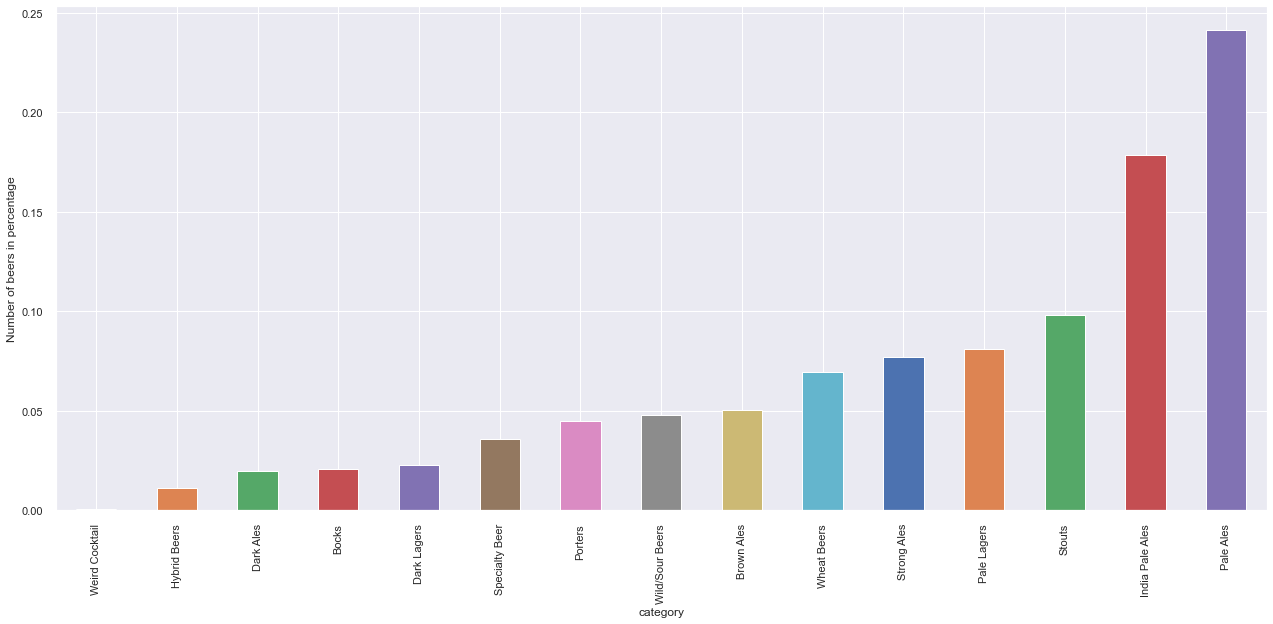

In [13]:
sns.set(rc={'figure.figsize':(21.7,9.27)})
total_beers=df_beers.shape[0]
palette = sns.color_palette(None, 15)
cat=df_beers.groupby('category').apply(lambda categ: categ.count()["beer_id"]/total_beers)
cat.sort_values().plot(kind = 'bar',color=palette)
plt.ylabel('Number of beers in percentage')

In this plot above, we can see the  number of beers in each category in percentage. Also, bigger the circle is more there are beers in the category.  We can see that 'Pale Ales' is quite highly represented (almost 25% of the beers are in this category).  The second most represented category is 'Indian Pale Ales'  (represented at almost 18%). For the further analysis, we will have to be  careful about how each category is represented.

We now focus on the average of the ratings for each category

In [14]:
df_beers.groupby('category')["avg"].describe()

,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
Bocks,5037.0,3.706750,0.438740,1.12,3.50,3.76,3.99,5.0
Brown Ales,12362.0,3.709714,0.420009,0.00,3.50,3.75,3.98,5.0
Dark Ales,4879.0,3.693782,0.418825,0.00,3.50,3.75,3.95,5.0
Dark Lagers,5563.0,3.559590,0.488692,0.00,3.32,3.65,3.88,5.0
Hybrid Beers,2739.0,3.629474,0.444672,1.00,3.43,3.68,3.90,5.0
India Pale Ales,45381.0,3.849004,0.389755,0.00,3.65,3.88,4.09,5.0
Pale Ales,58963.0,3.675394,0.425130,0.00,3.48,3.73,3.95,5.0
Pale Lagers,19642.0,3.324800,0.627132,0.00,2.96,3.46,3.77,5.0
Porters,11235.0,3.810827,0.405798,0.00,3.62,3.85,4.05,5.0


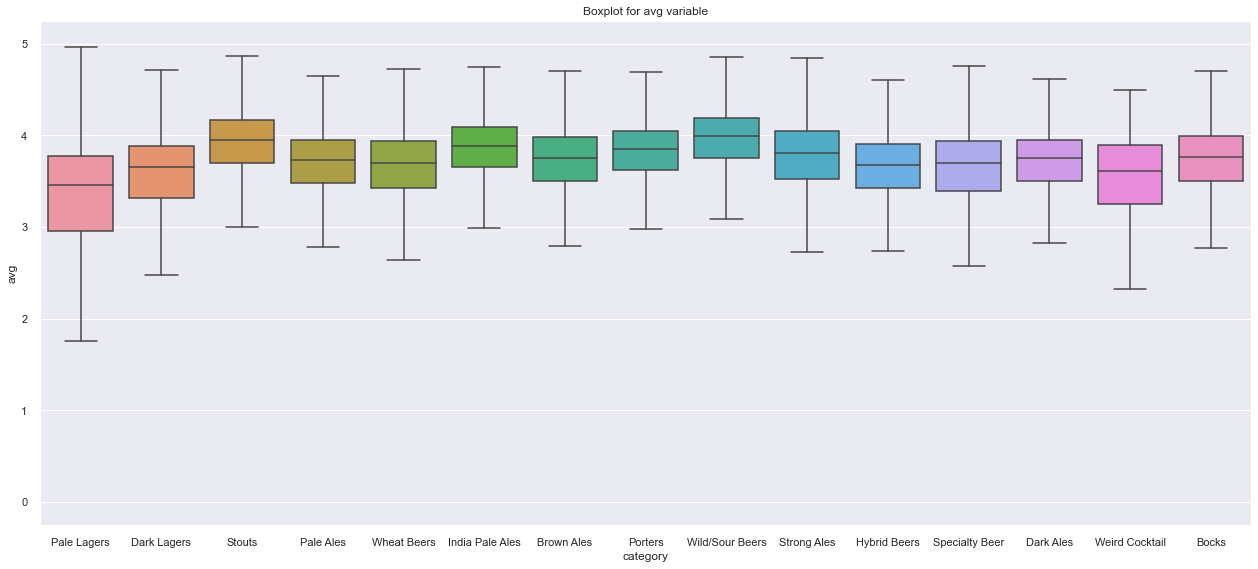

In [15]:

sns.boxplot(data=df_beers, x="category", y="avg",fliersize=0).set(
   title='Boxplot for avg variable')
pass

We can observe that there is not a lot of differences between the average of the ratings for each category. One can observe that the variance for the category 'Pale Lagers' is little higher. It can be explained by the large numbers of beers that falls in this category compared to others categories

## Dataset users.cvs

User informations are usefull to select valid user for our experiment. For exemple, we want only users from the USA (because they all have access to the same market) or users that have a reasonable number of ratings.

In [16]:
#load the data
df_users = pd.read_csv('./data/users.csv')
print(df_users.describe())
df_users.head(5)

         nbr_ratings    nbr_reviews        joined
count  153704.000000  153704.000000  1.510520e+05
mean       54.605163      16.847876  1.357238e+09
std       252.388790     139.846706  9.195131e+07
min         1.000000       0.000000  8.407944e+08
25%         1.000000       0.000000  1.303121e+09
50%         3.000000       0.000000  1.391944e+09
75%        16.000000       2.000000  1.417691e+09
max     12046.000000    8970.000000  1.501495e+09


,nbr_ratings,nbr_reviews,user_id,user_name,joined,location
0,7820,465,nmann08.184925,nmann08,1.199704e+09,"United States, Washington"
1,2521,2504,stjamesgate.163714,StJamesGate,1.191838e+09,"United States, New York"
2,1797,1143,mdagnew.19527,mdagnew,1.116410e+09,Northern Ireland
3,31,31,helloloser12345.10867,helloloser12345,1.101380e+09,Northern Ireland
4,604,604,cypressbob.3708,cypressbob,1.069326e+09,Northern Ireland


The features that characterize users are self-explanatory:
- nbr_ratings : the number of ratings a user has given
- nbr_reviews : the number of reviews a user has given
- user_id : internal database representation BeerAdvocate chose for their users
- user_name : the username chosen by the user on the website
- joined : the date when the users joined the website, expressed as a Unix timestamp
- location : where the users comes from

The difference between a review and a rating:

A review is a rating which the user decided to elaborate using a small text.
Users have the choice to comment their ratings: if they decide to do so, they are doing a review.
If they do not comment their rating, then BeerAdvocate refers to it as a rating.
Notice that every review is a rating, but not vice versa.

### Analysis

In [17]:
total_nb_users = df_users.user_name.nunique()
print("Total number of user : ", total_nb_users)
print("Number of user with 0 rating : ", df_users[df_users.nbr_ratings == 0].user_name.nunique())

Total number of user :  153703
Number of user with 0 rating :  0


In [18]:
#How many people from the US?
df_us_users = df_users[df_users.location.str.contains('United States', na = False)]
number_us_users = df_us_users.user_name.nunique()
print("Number of user from the USA : ",number_us_users)

print(f"{number_us_users/total_nb_users*100:.02f}% of the people comes from the USA.")


Number of user from the USA :  113222
73.66% of the people comes from the USA.


In [19]:
#Around all 50 states of America. -> distribution by state?
print("Number of states : ", df_us_users.location.nunique())

Number of states :  50


We choose to only keep users from the USA as they all have acces to the same beer market. Moreover, they represent a vast majority of the total user, we thus still have a large dataset to work with.

Let us now focus on the number of ratings done by US users.

With the help of a QQ-Plot, we can get a first grasp of the data distribution

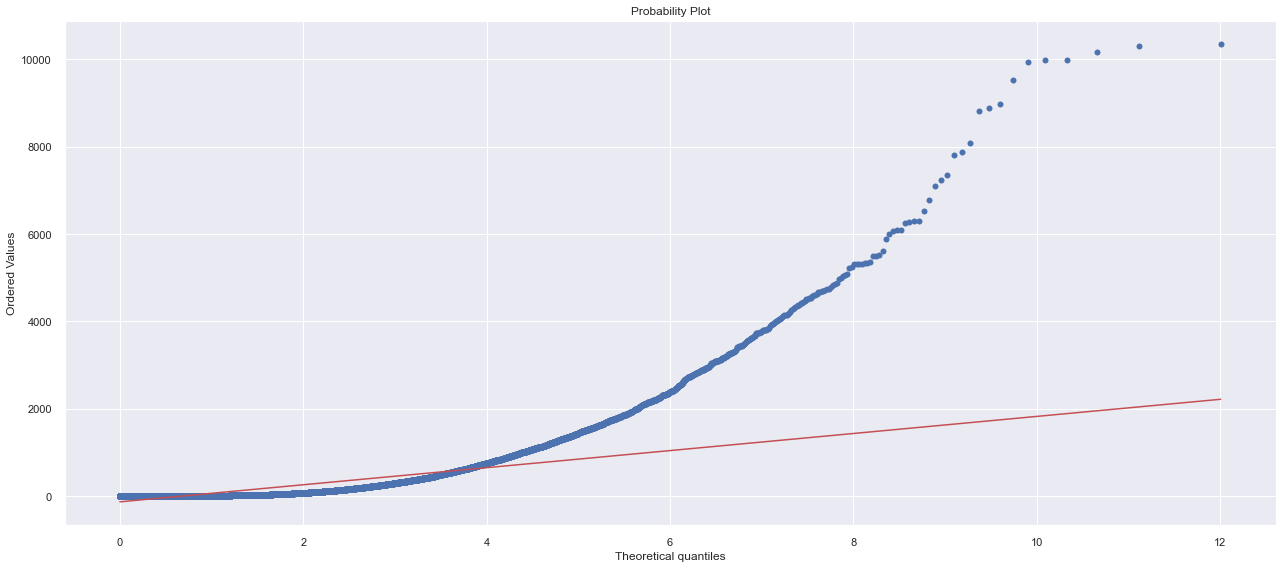

In [20]:
stats.probplot(df_us_users.nbr_ratings, dist = "expon", plot=pylab)
pass

The distribution looks extremely heavy tailed. 

Lets look at some simple statistics:

In [21]:
nb_ratings_us_users = df_us_users.nbr_ratings.sum()
print(nb_ratings_us_users)
df_us_users['nbr_ratings'].describe()

7303870


count    113223.000000
mean         64.508713
std         274.707015
min           1.000000
25%           1.000000
50%           4.000000
75%          22.000000
max       10360.000000
Name: nbr_ratings, dtype: float64

50% of US users rated less than 4 beers on the website.

In [22]:
percentile = np.arange(0.8, 1, 0.02)
df_us_users['nbr_ratings'].describe(percentiles= percentile)

count    113223.000000
mean         64.508713
std         274.707015
min           1.000000
50%           4.000000
80%          35.000000
82%          43.000000
84%          54.000000
86%          69.000000
88%          90.000000
90%         119.000000
92%         166.000000
94%         239.000000
96%         371.000000
98%         703.000000
max       10360.000000
Name: nbr_ratings, dtype: float64

With the above observation, we can clearly see that We have some heavy-hitters in our data-set, which we will need to filter out later on. 

For example, let us look at the 10 users with the most ratings

In [23]:
top_ten_us_users = df_us_users.sort_values(by = 'nbr_ratings', ascending = False).head(10)
top_ten_us_users

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location
1352,10360,66,acurtis.508168,acurtis,1.285582e+09,"United States, New Jersey"
1583,10302,34,texasfan549.572853,Texasfan549,1.298718e+09,"United States, Texas"
969,10180,2091,kylehay2004.571365,kylehay2004,1.298459e+09,"United States, Illinois"
994,9991,1122,grg1313.288024,GRG1313,1.232017e+09,"United States, California"
9,9987,16,jaydoc.265507,jaydoc,1.226488e+09,"United States, Kansas"
967,9944,8768,uclabrewn84.439438,UCLABrewN84,1.268910e+09,"United States, California"
672,9520,51,spycow.205702,spycow,1.206270e+09,"United States, Illinois"
1286,8970,8970,stonedtrippin.601042,StonedTrippin,1.306577e+09,"United States, Colorado"
516,8898,0,kjkinsey.472192,kjkinsey,1.277201e+09,"United States, Texas"
1353,8813,2,djrn2.389332,djrn2,1.257332e+09,"United States, New Jersey"


In [24]:
nb_ratings_top_ten = top_ten_us_users.nbr_ratings.sum()
print("Number of ratings done by the top 10 : ", nb_ratings_top_ten)
print(f"The top 10 has done {nb_ratings_top_ten/nb_ratings_us_users*100:.2f}% of the ratings")

Number of ratings done by the top 10 :  96965
The top 10 has done 1.33% of the ratings


10 users are responsible for roughly 1.3% of the total number of reviews!

We will have to be very careful in the way we select our users and need to determine a method to filter out outliers.

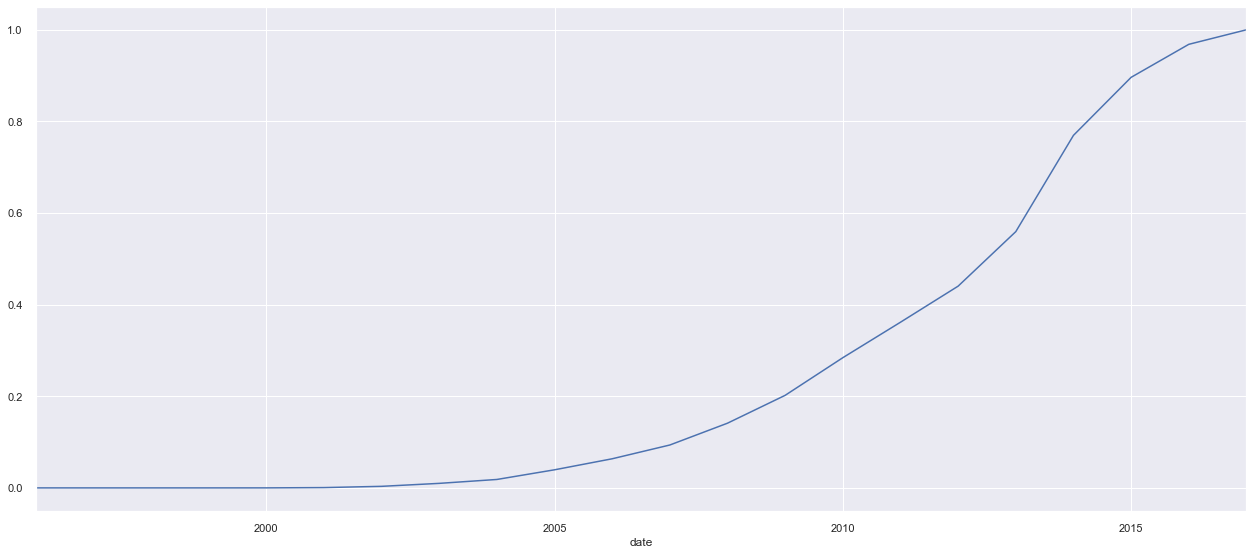

In [25]:
# Increase of number of US users through time.
df_us_users.loc[:,'date'] = pd.to_datetime(df_us_users['joined'].apply(lambda dt : datetime.fromtimestamp(dt).strftime('%Y-%m-%d')))
df_us_users.head(5)
df_users_year = df_us_users[['date','user_id']].groupby(pd.Grouper(freq = 'Y', key = 'date')).count()
df_users_year['cumulated'] = df_users_year['user_id'].cumsum().div(number_us_users)
df_users_year.cumulated.plot()
pass

In [26]:
# 7 people joined before the ratings that we have? Who are they lol

joined_before = pd.to_datetime('2001-01-01')
us_users_joined = df_us_users[df_us_users.date < joined_before]
us_users_joined

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location,date
42,1888,1887,beeradvocate.1,BeerAdvocate,840794400.0,"United States, Massachusetts",1996-08-23
163,4602,3561,jason.3,Jason,840794400.0,"United States, Massachusetts",1996-08-23
165,1699,1085,todd.2,Todd,840794400.0,"United States, California",1996-08-23
6498,18,16,javier.9,javier,977396400.0,"United States, Massachusetts",2000-12-21
18250,125,106,qxster1.12,QXSTER1,977742000.0,"United States, Pennsylvania",2000-12-25
23074,6,2,mevans05.6,mevans05,977310000.0,"United States, Massachusetts",2000-12-20
76584,1,0,mmakunas.10,mmakunas,977396400.0,"United States, California",2000-12-21


Wow, we found the founders of Beer Advocate: the two brothers, Jason and Todd Alstrom!! xD xD xD xD xD XD XD XD XD

Say HI to them!!

<img src="./data/creators.jpeg" class="img-responsive" alt=""> </div>

This also shows us that there are some organizations on the website : filtering must be done!!

### Filtering of users (first part)

Based on the previous analysis, we will now select a set of valid user. A second filtering will be done later (see above).

In [27]:
#keep user from the USA only
df_us_users = df_users[df_users.location.str.contains('United States', na=False)]

#choose a minimum number of ratings per user, since we want to analyse an evolution
cutoff_low = 10 #subjective, good so ?
print("Cuttof low : ", cutoff_low)

#choose a maximum number of ratings per user, we want to filter our super-users or organisations
cutoff_high = df_us_users.nbr_ratings.quantile(0.99)
print("Cuttof low : ", cutoff_high)

#create a valid user dataframe and a set with the valid user_names
df_valid_us_users = df_us_users[(df_us_users.nbr_ratings < cutoff_high) &
                                (df_us_users.nbr_ratings >= cutoff_low)]
valid_us_users_names = set(df_valid_us_users.user_name)
print("Number of users left : ", len(valid_us_users_names))
print("total of ratings left : ", df_valid_us_users.nbr_ratings.sum())

Cuttof low :  10
Cuttof low :  1135.0
Number of users left :  39548
total of ratings left :  4675463


With this filtering, outliers are remooved and we still have enough data to work with. The filtering we did is subjective, and can still be adapted.

Note that we will still have to filter more based on the file ratings.txt

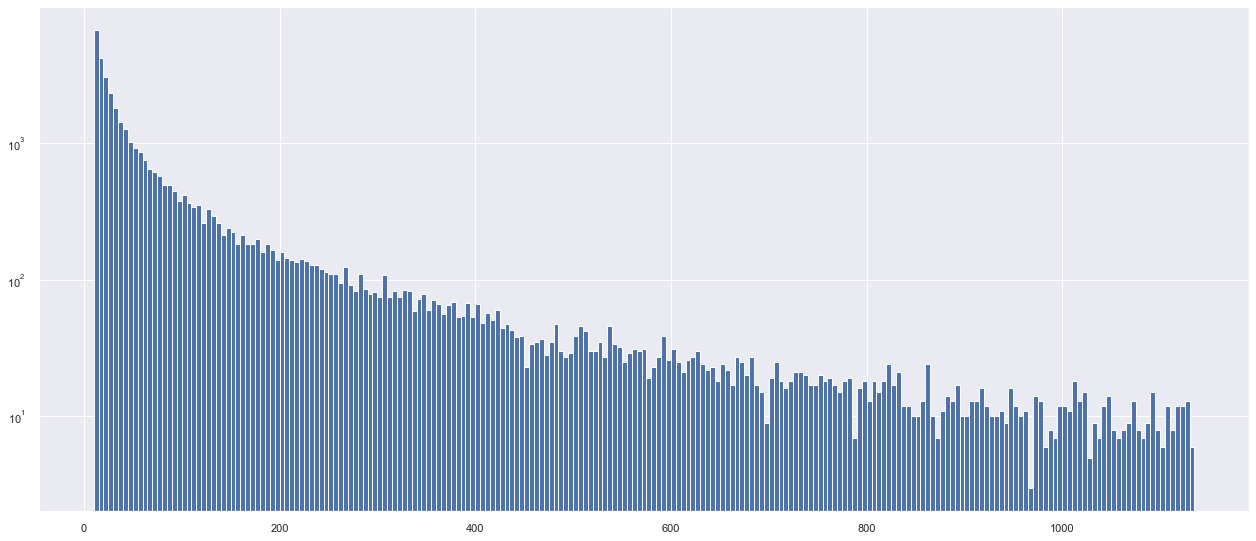

In [28]:
#the above plot shows the number of user per rating number, it looks like an exponential distribution
binwidth = 5
plt.hist(df_valid_us_users.nbr_ratings, bins=range(min(df_valid_us_users.nbr_ratings),
         max(df_valid_us_users.nbr_ratings) + binwidth, binwidth), log=True)
pass

## Dataset reviews.txt.gz

This will be our main dataset. It contains the informations we want to build our datastory on.

However, the format used to store the data is not universal and is not supported by pandas reading functions. We have adapted an helper function to parse the txt.gz file and return a generator. The generator is then used to recurively build the pandas dataframe.

In [29]:
def parse(filename):
    """
    Parse a txt.gz file and return a generator for it
    Copyright © 2017 Gael Lederrey <gael.lederrey@epfl.ch>
    :param filename: name of the file
    :return: Generator to go through the file
    """
    file = gzip.open(filename, 'rb')
    entry = {}
    # Go through all the lines
    for line in file:
        # Transform the string-bytes into a string
        line = line.decode("utf-8").strip()

        # We check for a colon in each line
        colon_pos = line.find(":")
        if colon_pos == -1:
            # if no, we yield the entry
            yield entry
            entry = {}
            continue
        # otherwise, we add the key-value pair to the entry
        key = line[:colon_pos]
        value = line[colon_pos + 2:]
        entry[key] = value

To build the dataframe, we have implemented a framework that goes trought the generator and only keeps the desired column. Simply loading the whole dataset was costly because some features where too heavy for ours computers (mainly the text review, total dataset size of 0.9Gb). We have also casted some of the columns to the right datatype to save some space (e.g. casting the column "beer_id" as an int is lighter than keeping it as a pandas object). 

In [30]:
gen = parse('./data/ratings.txt.gz')

In [4]:
create = False

if create:
    undesired_features = set(['text','review', 'brewery_name', 'brewery_id', 'user_id', 'beer_name'])
    full_ratings_ls = []
    int_cols = ['beer_id']
    float_cols = ['abv','appearance', 'aroma', 'palate', 'taste', 'overall', 'rating']

    review = next(gen)
    cols = [key for key, _ in review.items() if key not in undesired_features]

    for idx, review in enumerate(gen):
        user_name = review['user_name']
        valid_rows = [value for key, value in review.items() if key not in undesired_features]
        if user_name in valid_us_users_names:
            full_ratings_ls.append(valid_rows)

    df_ratings = pd.DataFrame(full_ratings_ls, columns = cols)

    df_ratings[int_cols] = df_ratings[int_cols].astype('int')
    df_ratings[float_cols] = df_ratings[float_cols].astype('float') 
    df_ratings["date"] = pd.to_datetime(df_ratings.date.apply(
        lambda date : datetime.datetime.fromtimestamp(int(date)).strftime('%Y-%m-%d')
    ))

    #There is one review in 2000, wich is an outlier
    start_date = pd.to_datetime("2001-01-01")
    df_ratings = df_ratings.loc[df_ratings['date'] >= start_date]   
    df_ratings.to_pickle('./data/ratings_us.pkl')

else:
    df_ratings = pd.read_pickle('./data/ratings_us.pkl')

The dataframe is then saved in pickle format. 

In [32]:
print(df_ratings.shape)
df_ratings.head(5)
#4675432

(4675431, 11)


,beer_id,style,abv,date,user_name,appearance,aroma,palate,taste,overall,rating
0,19827,English Pale Ale,4.8,2014-02-10,OKCNittany,NaN,NaN,NaN,NaN,NaN,3.75
1,19827,English Pale Ale,4.8,2013-02-13,brewdude1982,4.25,4.5,3.25,3.75,3.75,3.91
2,19827,English Pale Ale,4.8,2012-12-02,BYOFB,NaN,NaN,NaN,NaN,NaN,3.50
3,19827,English Pale Ale,4.8,2012-11-24,CadensDad,NaN,NaN,NaN,NaN,NaN,4.00
4,19827,English Pale Ale,4.8,2012-11-17,ferrari29,3.00,3.5,2.50,2.50,2.50,2.77


We can now perfom some analysis to explore the data. 

### Ratings

We want to see how much rating they is in each beer category

To do so, we first have to add a column where each style is mapped to its parents beer style.

In [33]:

beers_id_cat = df_beers[['beer_id', 'category']]
df_ratings_cat = pd.merge(df_ratings, beers_id_cat, on = 'beer_id')

if False:
    df_ratings_cat.to_pickle("./data/df_ratings_cat.pkl")
if False:
    df_ratings_cat = pd.read_pickle("./data/df_ratings_cat.pkl")

In [34]:
print(df_ratings_cat[["style", "category"]].sample(3))


#We have 15 unique categegories, as expected
print("number of category : ", df_ratings_cat.category.nunique())

                                    style   category
3131862  American Double / Imperial Stout     Stouts
2545787                      Scottish Ale  Dark Ales
1015611                     Winter Warmer  Dark Ales
number of category :  15


<AxesSubplot:xlabel='category'>

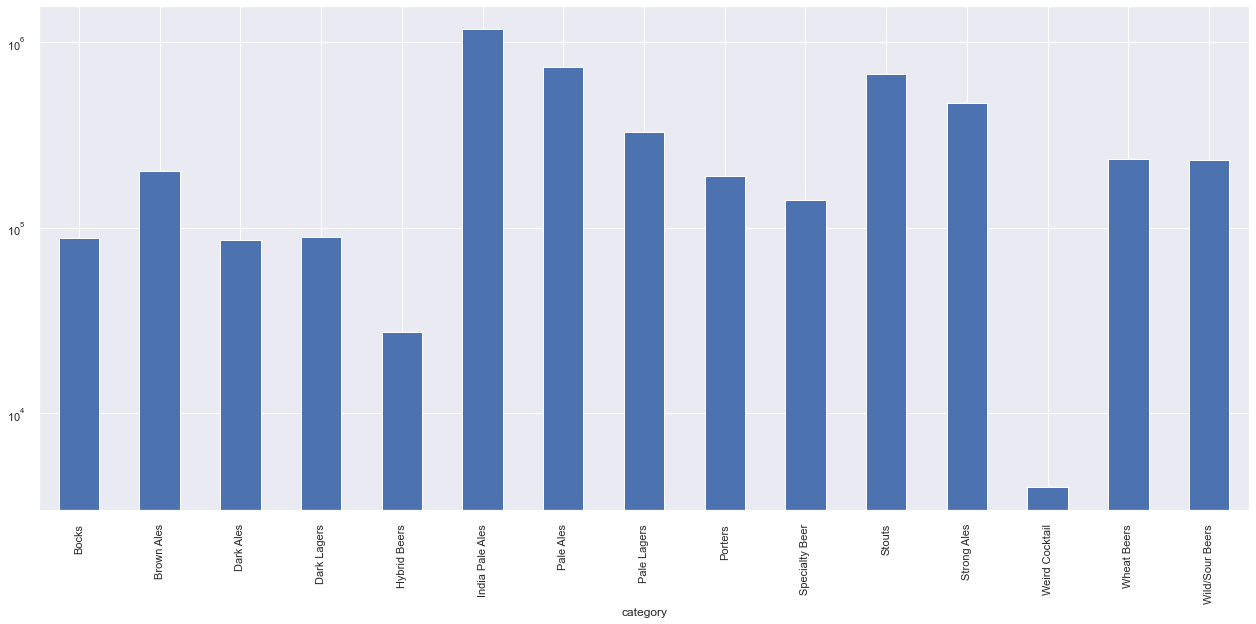

In [35]:
#Distribution of all ratings on the website!
df_category_cnt = df_ratings_cat.groupby('category').rating.count()
df_category_cnt.plot(kind = 'bar', logy = True)

### Ratings over time

Fist, we will look at the distribution of all the ratings of the valid user over time. 

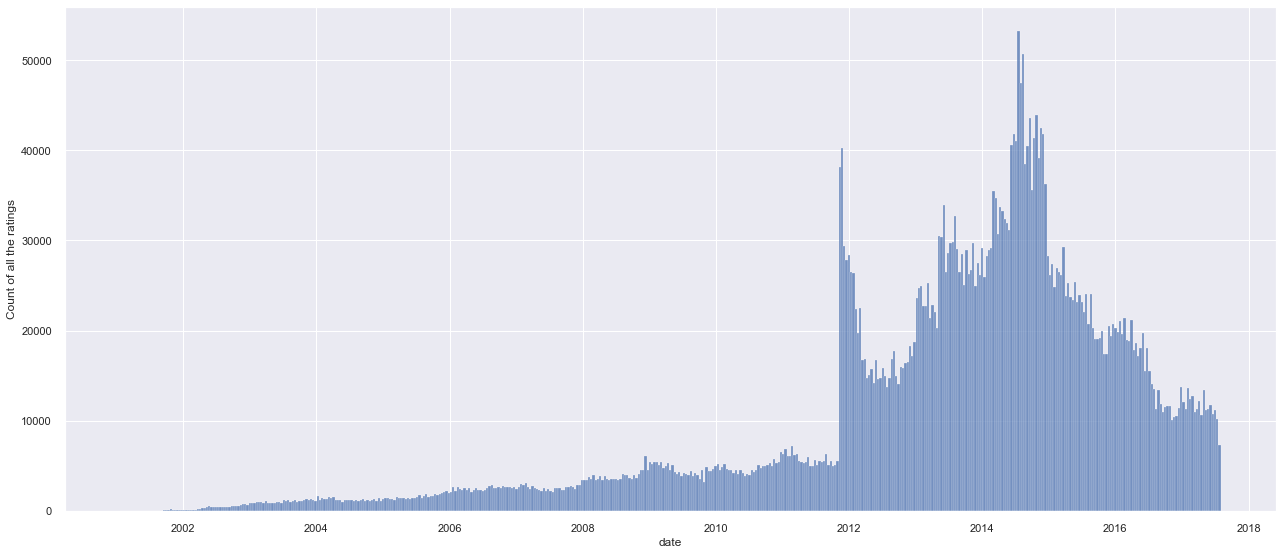

In [36]:
fig, ax1 = plt.subplots()
sns.histplot(df_ratings.date)
ax1.set_xlabel('date')
ax1.set_ylabel('Count of all the ratings')
plt.show()

Then we are also intersted in finding the first rating of each user (i.e. thier joining date)

In [37]:
first_rating_per_user=df_ratings.groupby(['user_name']).apply(lambda group : group.date.min())

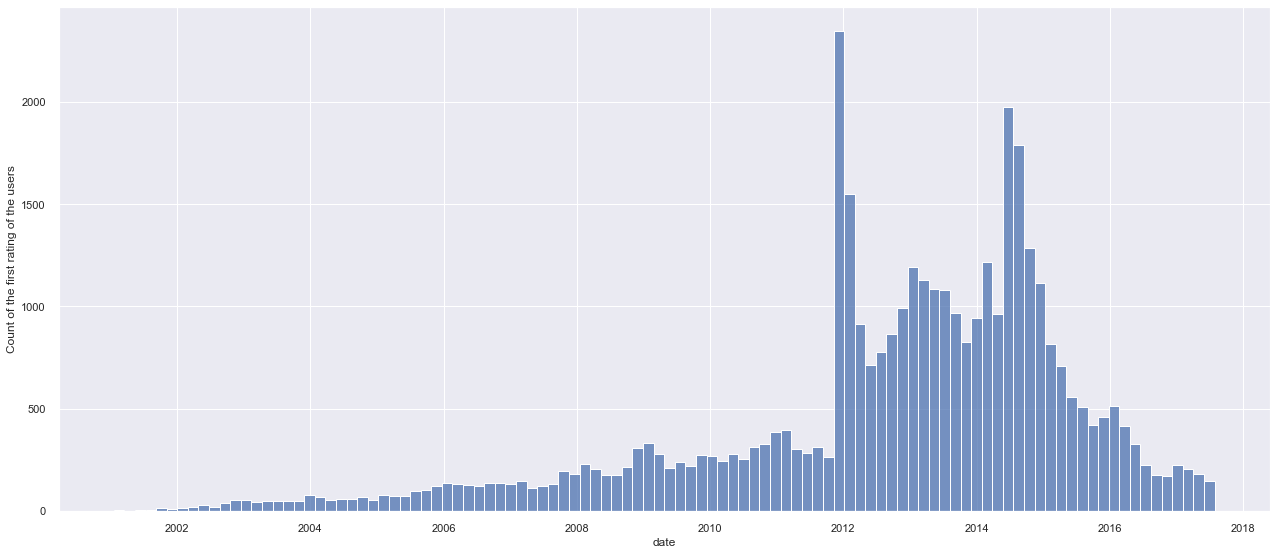

In [38]:
fig, ax1 = plt.subplots()
sns.histplot(first_rating_per_user)
ax1.set_xlabel('date')
ax1.set_ylabel('Count of the first rating of the users')
plt.show()

In both case, there is a huge spike in 2012. We did some researched, and apparently, beerAdvocate had a data breach in this period. We dont think that this will be a probleme for our analysis thought. 

#WHY ??

### ratings of each category of beer over time

We want to see how each category of beer evolves over time. We will plot the number of rating per category over time.

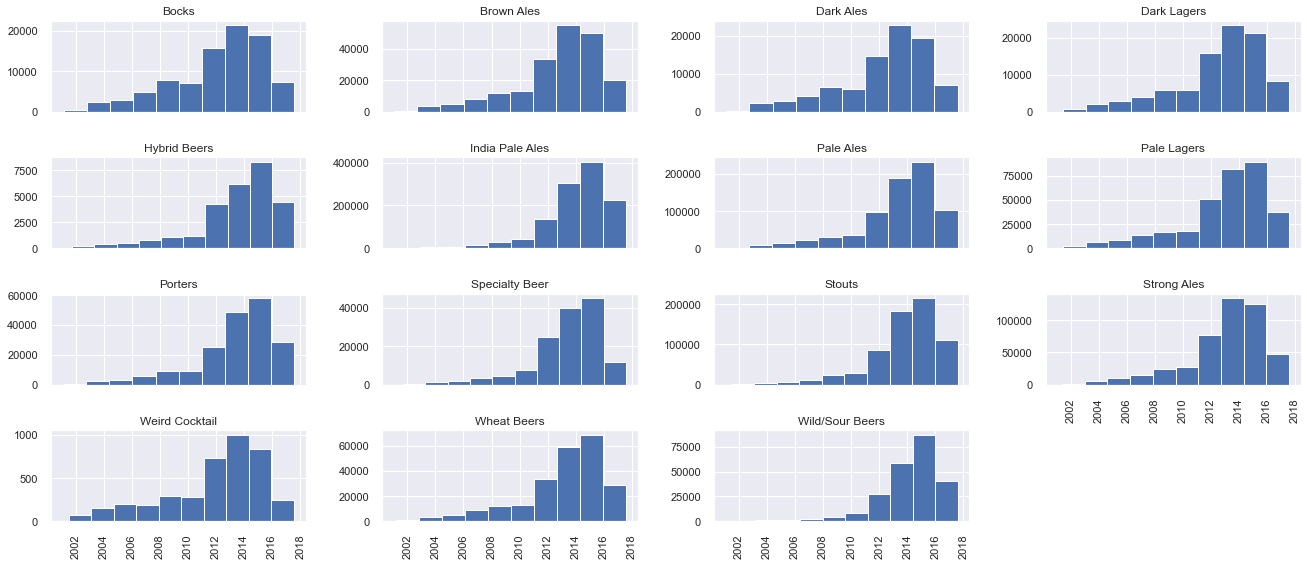

In [39]:
#time serie of each beer /!\ the y axis is NOT the same 
df_ratings_cat["date"].hist(by=df_ratings_cat["category"], sharex=True, sharey=False)
pass

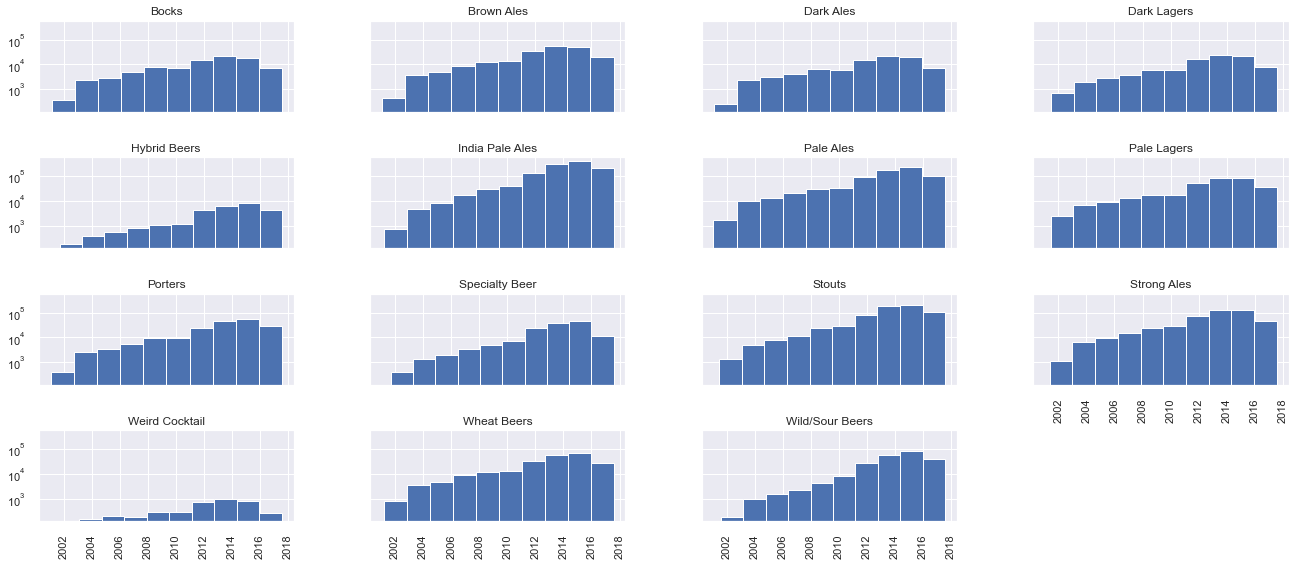

In [40]:
#the same graph, with a log scale and shared y-axis
df_ratings_cat["date"].hist(by=df_ratings_cat["category"], sharex=True, sharey=True, log = True)
pass

These plot are hardly readable, and even less comparable. It would be better to plot everything on a same graph. This required that we normalize each category by the total number of ratings in a chosen timeframe. Here, we choose to look at the distribution considering bins of one year.

In [41]:
#here we count how much ratings each category recieved for each year
cat_year = df_ratings_cat.groupby([pd.Grouper(freq="Y", key="date"), "category"])["beer_id"].count().reset_index()
print(cat_year.sample(3))
print(cat_year.shape)

          date      category  beer_id
17  2002-12-31     Dark Ales      516
169 2012-12-31  Hybrid Beers     3047
23  2002-12-31       Porters      534
(255, 3)


In [42]:
#Total number of ratings per year
review_year = cat_year.groupby("date").sum().reset_index()
print(review_year.sample(3))
print(review_year.shape)

         date  beer_id
6  2007-12-31    75250
15 2016-12-31   458337
10 2011-12-31   292483
(17, 2)


In [43]:
#For each row (i.e. beer category over one year), we want to have both the number of ratings of
# the category and the total number of ratings over all the category over the year.
merge_data=cat_year.merge(review_year, left_on="date", right_on="date")
merge_data['ratio']=merge_data["beer_id_x"]/merge_data["beer_id_y"]
print(merge_data.sample(3))
merge_data.shape
merge_data.sort_values(by = "date").head()

          date         category  beer_id_x  beer_id_y     ratio
14  2001-12-31  Wild/Sour Beers          5        922  0.005423
59  2004-12-31  Wild/Sour Beers        705      36779  0.019169
245 2017-12-31  India Pale Ales      70550     196377  0.359258


,date,category,beer_id_x,beer_id_y,ratio
0,2001-12-31,Bocks,34,922,0.036876
14,2001-12-31,Wild/Sour Beers,5,922,0.005423
13,2001-12-31,Wheat Beers,49,922,0.053145
12,2001-12-31,Weird Cocktail,11,922,0.011931
11,2001-12-31,Strong Ales,101,922,0.109544


In [44]:
#Each style over the whole period is grouped in a list of list
hists = []
for cat in merge_data["category"].unique():
    hists.append(merge_data.ratio[merge_data["category"]==cat].to_list())

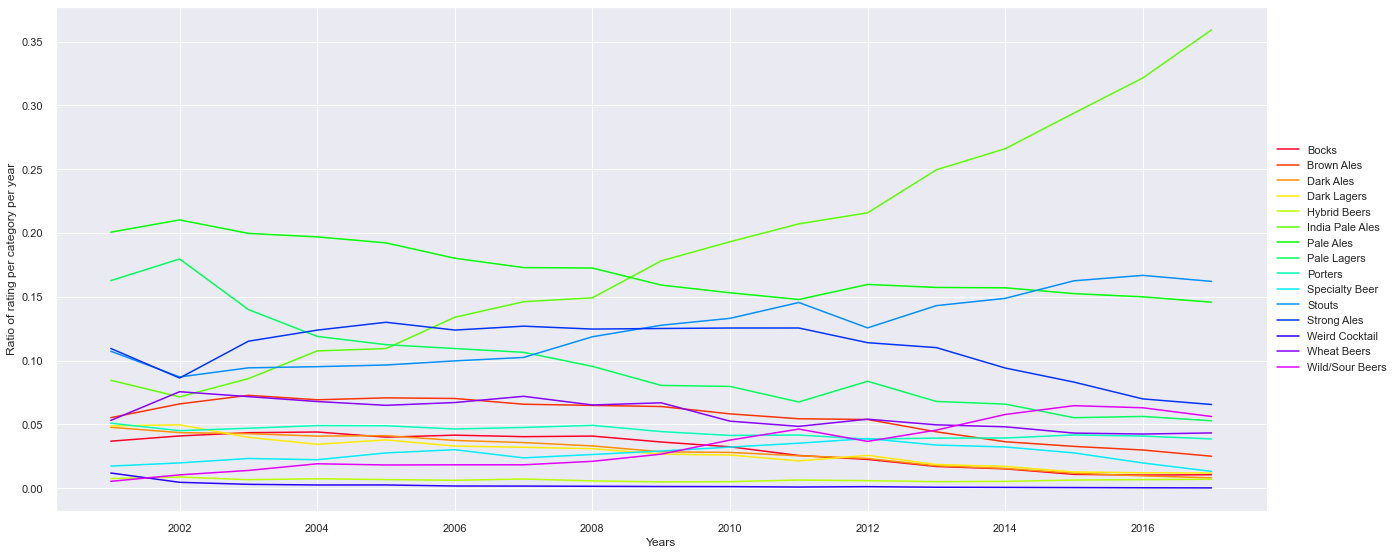

In [45]:
x = range(2001,2019)

cm = plt.get_cmap('gist_rainbow')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[cm(1.*i/15) for i in range(15)])
for i, hist in enumerate(hists):
    ax.plot(x[0:len(hist)],hist, label=merge_data["category"].unique()[i])
    pass

plt.xlabel("Years")
plt.ylabel("Ratio of rating per category per year")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

The final graph gives us much informations. It shows for each year, the percentage of ratings that each style of beer got.

In 2017, 35% of the ratings are of IPAs !
we can clearly see the rise of popularity for the IPAs and Stouts, it will be important to take this into account when evaluating the evolution on a single user.


### User's 5 first and last ratings

Since we want to investigate the evolution of the user's taste over time, it would be interesting to see with wich beer the user "started" and "ended".

 We will look at the distribution of each beer category over the five first ratings of all the users. In other words, beers which category will the user rate first.

In [46]:
df_ratings_cat.head(1)

,beer_id,style,abv,date,user_name,appearance,aroma,palate,taste,overall,rating,category
0,19827,English Pale Ale,4.8,2014-02-10,OKCNittany,NaN,NaN,NaN,NaN,NaN,3.75,Pale Ales


# a partir de la j'ai juste copier le code, peut tre quon peut epurer

In [47]:
def first_ratings_user(ratings, first = 5, last = 5):
    ratings_sorted = ratings.sort_values(by = 'date')
    first_ratings = ratings_sorted[:first]
    last_ratings = ratings_sorted[-last:]
    first_categories = list(set(first_ratings.category))
    last_categories = list(set(last_ratings.category))
    return first_categories, last_categories

In [48]:

#SLOW
df_first = df_ratings_cat[['user_name', 'date', 'category']]
df_first = df_first.groupby('user_name').apply(lambda user_rating: pd.Series({'first_last_cats' : first_ratings_user(user_rating)})).reset_index()
df_first['first_cats'] = df_first['first_last_cats'].apply(lambda cats: cats[0])
df_first['last_cats'] = df_first['first_last_cats'].apply(lambda cats: cats[1])
df_first = df_first.drop(['first_last_cats'], axis = 1)

In [49]:
#Try to check if some categories (dis)appear between the first 5 and the last 5 ratings

df_first['nb_cat_first'] = df_first['first_cats'].apply(lambda cat: len(cat))
df_first['nb_cat_last'] = df_first['last_cats'].apply(lambda cat: len(cat))
df_first.head(5)

,user_name,first_cats,last_cats,nb_cat_first,nb_cat_last
0,--Dom--,"[Stouts, India Pale Ales, Strong Ales]","[India Pale Ales, Bocks, Pale Lagers]",3,3
1,-MK-,"[Wheat Beers, India Pale Ales, Dark Lagers, Hy...","[India Pale Ales, Dark Lagers, Pale Lagers, Pa...",4,5
2,-NESTO-,"[Stouts, Wheat Beers, Strong Ales]","[Wild/Sour Beers, Pale Ales, India Pale Ales, ...",3,4
3,-Rick,"[India Pale Ales, Pale Ales]","[Wild/Sour Beers, India Pale Ales, Brown Ales,...",2,4
4,-Royce-,"[Wild/Sour Beers, Pale Ales]","[Wild/Sour Beers, Strong Ales, Wheat Beers, Pa...",2,4


#### User diverity in the 5 first ratings

Text(0.5, 1.0, 'How many different categories valid users mention in their first 5 ratings')

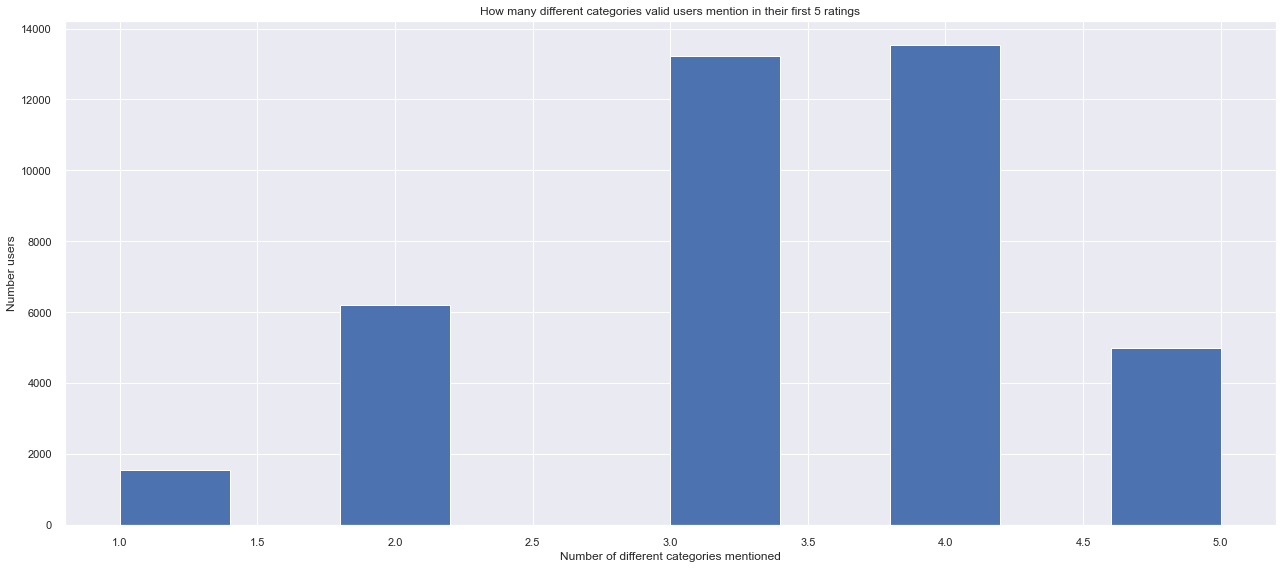

In [50]:
plt.hist(df_first.nb_cat_first)
plt.xlabel('Number of different categories mentioned')
plt.ylabel('Number users')
plt.title('How many different categories valid users mention in their first 5 ratings')

Text(0.5, 1.0, 'How many different categories valid users mention in their last 5 ratings')

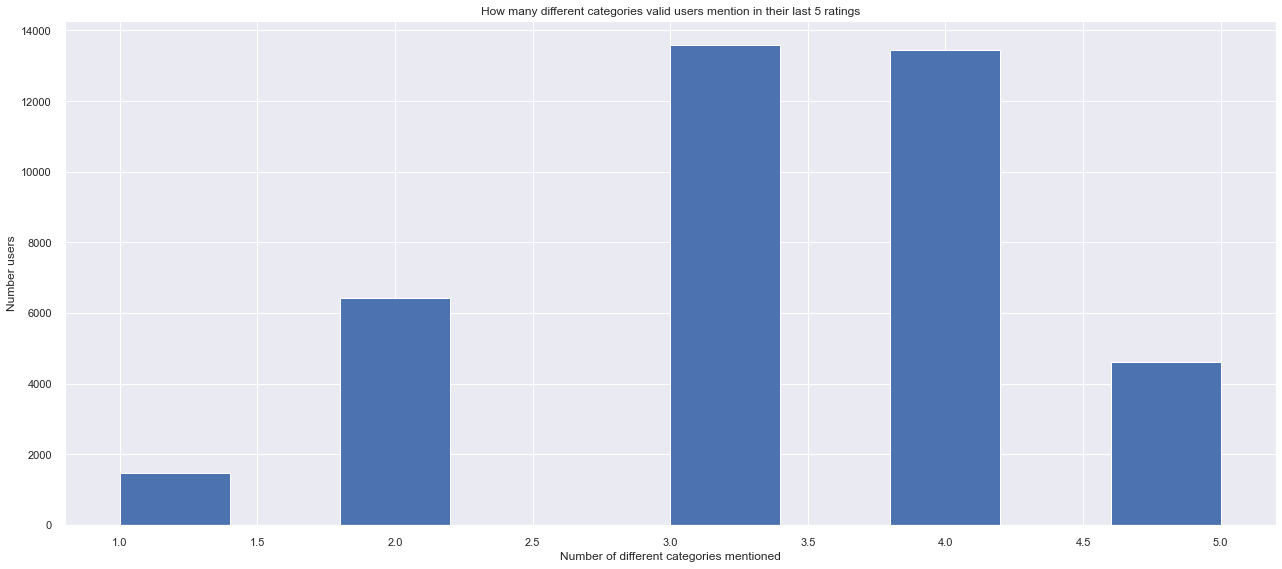

In [51]:
plt.hist(df_first.nb_cat_last)
plt.xlabel('Number of different categories mentioned')
plt.ylabel('Number users')
plt.title('How many different categories valid users mention in their last 5 ratings')

#### Wich category dominated

In [52]:
first_categories = df_first['first_cats']
last_categories = df_first['last_cats']

In [53]:
def category_counter(categories):
    mydict = {}
    for first_categories in categories:
        for cat in first_categories:
            if cat in mydict.keys():
                mydict[cat] += 1
            else:
                mydict[cat] = 1 
    return mydict

In [54]:
first_categories_dict = category_counter(first_categories)
last_categories_dict = category_counter(last_categories)
first_categories_dict

{'Stouts': 17602,
 'India Pale Ales': 24816,
 'Strong Ales': 15185,
 'Wheat Beers': 8981,
 'Dark Lagers': 4519,
 'Hybrid Beers': 1162,
 'Pale Ales': 19771,
 'Wild/Sour Beers': 3620,
 'Bocks': 3761,
 'Weird Cocktail': 249,
 'Porters': 6380,
 'Specialty Beer': 5163,
 'Brown Ales': 7756,
 'Dark Ales': 3742,
 'Pale Lagers': 10152}

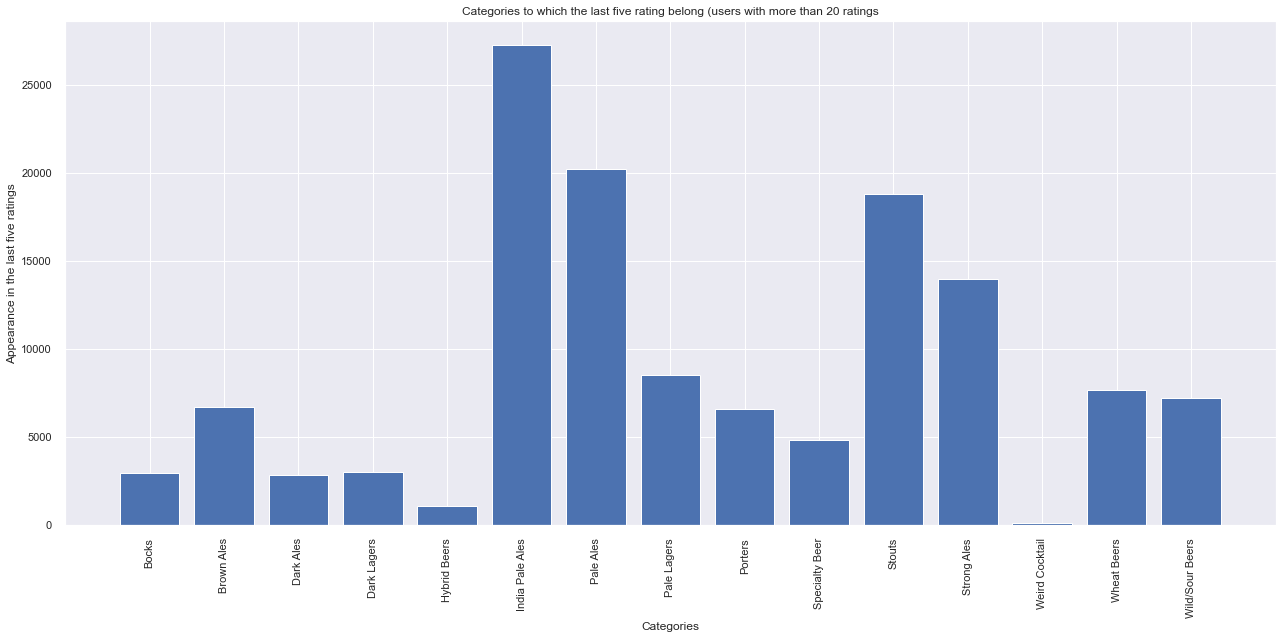

In [55]:
#General distribution of the last five ratings!

vals = []
for cat, count in last_categories_dict.items():
    vals.append((cat,count))
vals = sorted(vals, key = lambda tup: tup[0])

cat_last = []
count_last = []

for val in vals:
    cat_last.append(val[0])
    count_last.append(val[1])

plt.bar(cat_last, count_last)
plt.xlabel('Categories')
plt.xticks(rotation = 90)
plt.ylabel('Appearance in the last five ratings')
plt.title("Categories to which the last five rating belong (users with more than 20 ratings")
pass

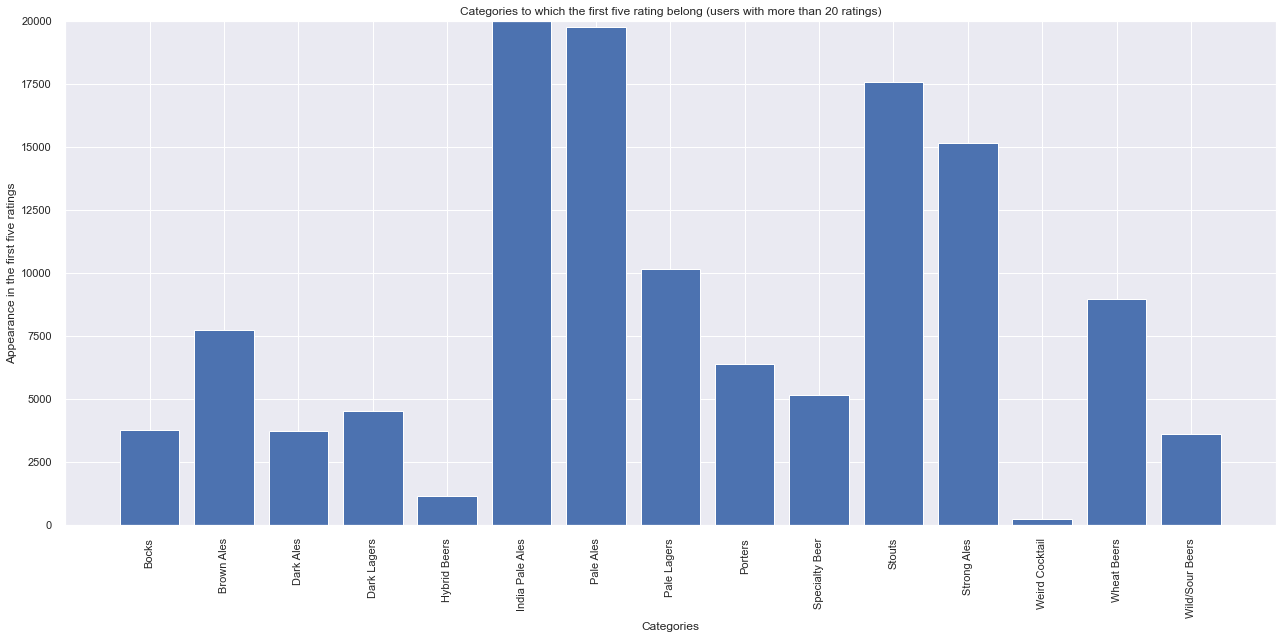

In [56]:
#General distribution of the five first ratings!

vals = []
for cat, count in first_categories_dict.items():
    vals.append((cat,count))
vals = sorted(vals, key = lambda tup: tup[0])

cat_first = []
count_first = []

for val in vals:
    cat_first.append(val[0])
    count_first.append(val[1])

plt.bar(cat_first, count_first)
plt.xlabel('Categories')
plt.xticks(rotation = 90)
plt.ylim(0,20000)
plt.ylabel('Appearance in the first five ratings')
plt.title("Categories to which the first five rating belong (users with more than 20 ratings)")
pass


Below, the percentage of change between 5 first and 5 last beers. We see some clear change, but is it due to a global trend ? And how to know that ? 

In [57]:
change_percentage = []
for count_f, count_l in zip(count_first,count_last):
    change_percentage.append((count_l-count_f)/count_f)
df_percentage = pd.DataFrame(change_percentage, cat_first)
df_percentage

,0
Bocks,-0.214305
Brown Ales,-0.133703
Dark Ales,-0.242918
Dark Lagers,-0.337685
Hybrid Beers,-0.042169
India Pale Ales,0.099049
Pale Ales,0.024278
Pale Lagers,-0.157013
Porters,0.032445
Specialty Beer,-0.062173


#### Filtering the users (second part)

In this part, we focus on a second filter on the users in order to keep users with the same behaviour.

We first create a new variable 'Different days' which corresponds to the difference number of days between his a first rating and his last rating.

In [58]:
#Difference in days between fisrt review and last review
diff_rating_per_user=df_ratings.groupby(['user_name']).apply(lambda group : group.date.max()-group.date.min())
diff_rating_per_user.name='Different days'
diff_rating_per_user=pd.DataFrame(diff_rating_per_user)
new_frame=df_ratings
new_frame=df_ratings.merge(diff_rating_per_user,right_on='user_name', left_on = 'user_name')

We also create the variable 'total_rating_user' which corresponds to the total number of rating made by a given user.

In [59]:
#Number of ratings per users
total_rating_user=df_ratings.groupby('user_name').count().rating
total_rating_user=pd.DataFrame(total_rating_user)
new_frame=new_frame.merge(total_rating_user,right_on='user_name', left_on = 'user_name',suffixes=['',' total of the user'])

The variable 'Number of day active' has also been created to capture the numbers of different days that the users connected to the website to add a review.

In [60]:
#create a column number of days active
number_of_day_active=df_ratings.groupby(['user_name']).date.unique()
number_of_day_active.name='Number'
number_of_day_active=pd.DataFrame(number_of_day_active)
number_of_day_active['Number of day active']=number_of_day_active.apply(lambda g : len(g.Number),axis=1)
del number_of_day_active['Number']
new_frame=new_frame.merge(number_of_day_active,right_on='user_name', left_on = 'user_name')

<AxesSubplot:xlabel='Number of day active', ylabel='Count'>

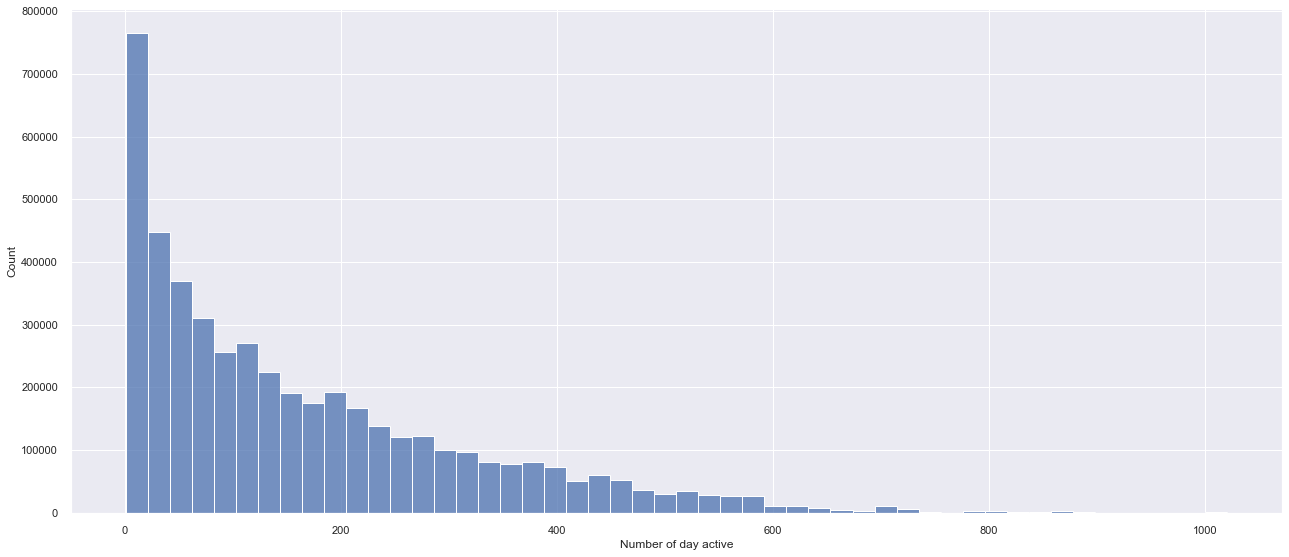

In [61]:
sns.histplot(new_frame['Number of day active'],bins=50)

In [62]:
new_frame['Number of day active'].describe()

count    4.675431e+06
mean     1.645241e+02
std      1.557807e+02
min      1.000000e+00
25%      3.900000e+01
50%      1.170000e+02
75%      2.460000e+02
max      1.020000e+03
Name: Number of day active, dtype: float64

If we have a look on the distribution of the number of day active of the users, we observe that 25% of the users are only active 4 days. We think that this kind of users will not be really useful for the further analyse we will make


We also create the variable 'Ratio reviews per active days' which is the ratio between the 'rating total of the user' and 'Number of day active'.

In [63]:
new_frame['Ratio reviews per active days']=new_frame['rating total of the user']/new_frame['Number of day active']

In [64]:
new_frame['Ratio reviews per active days'].describe()

count    4.675431e+06
mean     4.796696e+00
std      9.805840e+00
min      1.000000e+00
25%      1.742138e+00
50%      2.428571e+00
75%      4.112994e+00
max      3.020000e+02
Name: Ratio reviews per active days, dtype: float64

We observe that more 75% of the users made in average 4 ratings per day active which is quite reasonable in order to see a certain evolution of the users.

For preliminairy results, we decided to remove (it would be maybe changed later) the users with activity (in total) less than 365 days (one year), with 100 days of active days at least and 'Ratio reviews per active days' with more than 20.

In [65]:
print(' we have',new_frame[(new_frame['Ratio reviews per active days']<21) & (new_frame['Number of day active']>99) & (new_frame['Different days']>timedelta(365))].user_name.nunique(),'users left')

 we have 5515 users left


In [66]:
#Create the list of users we want to keep
list_users_kept=set(new_frame[(new_frame['Ratio reviews per active days']<21) & (new_frame['Number of day active']>99) & (new_frame['Different days']>timedelta(365))].user_name.unique())

# Taste evolution analysis

To see the order in which the users explore the beer categories, we compute the average number of ratings the users do before making the first one in each category.

In [5]:
cats = df_ratings["category"].unique()
cat_dict = {}
for cat, i in zip(cats, range(len(cats))):
    cat_dict[cat] = i

In [6]:
beer_num = np.zeros(len(cats))
beer_count = np.zeros(len(cats))

df_ratings.sort_values(by = "date", inplace=True)
ratings_user = df_ratings.groupby("user_name")
for user, group in ratings_user:
    beer_once = np.zeros(len(cats))
    for cat, i in zip(group["category"], range(len(group["category"]))):
        if not beer_once[cat_dict[cat]]:
            beer_num[cat_dict[cat]] += i
            beer_count[cat_dict[cat]] += 1
            beer_once[cat_dict[cat]] = True


beer_num_mean = np.divide(beer_num, beer_count)


In [7]:
cats_list = list(cats)
beer_num_mean_list = list(beer_num_mean)

rating_order = pd.DataFrame([(x,round(y,3)) for y, x in sorted(zip(beer_num_mean_list, cats_list))])
rating_order = rating_order.rename(columns={0: "category", 1: "mean first rating number"})
cat_count = df_ratings.groupby("category").count()
rating_order = rating_order.set_index("category").join(cat_count["beer_id"]).reset_index().rename(columns={"beer_id":"number of rating"})

We plot each category in order with the size of the bubbles representing the number of rating for each category.

Text(0, 0.5, 'Avg number of rating before first rating in the category')

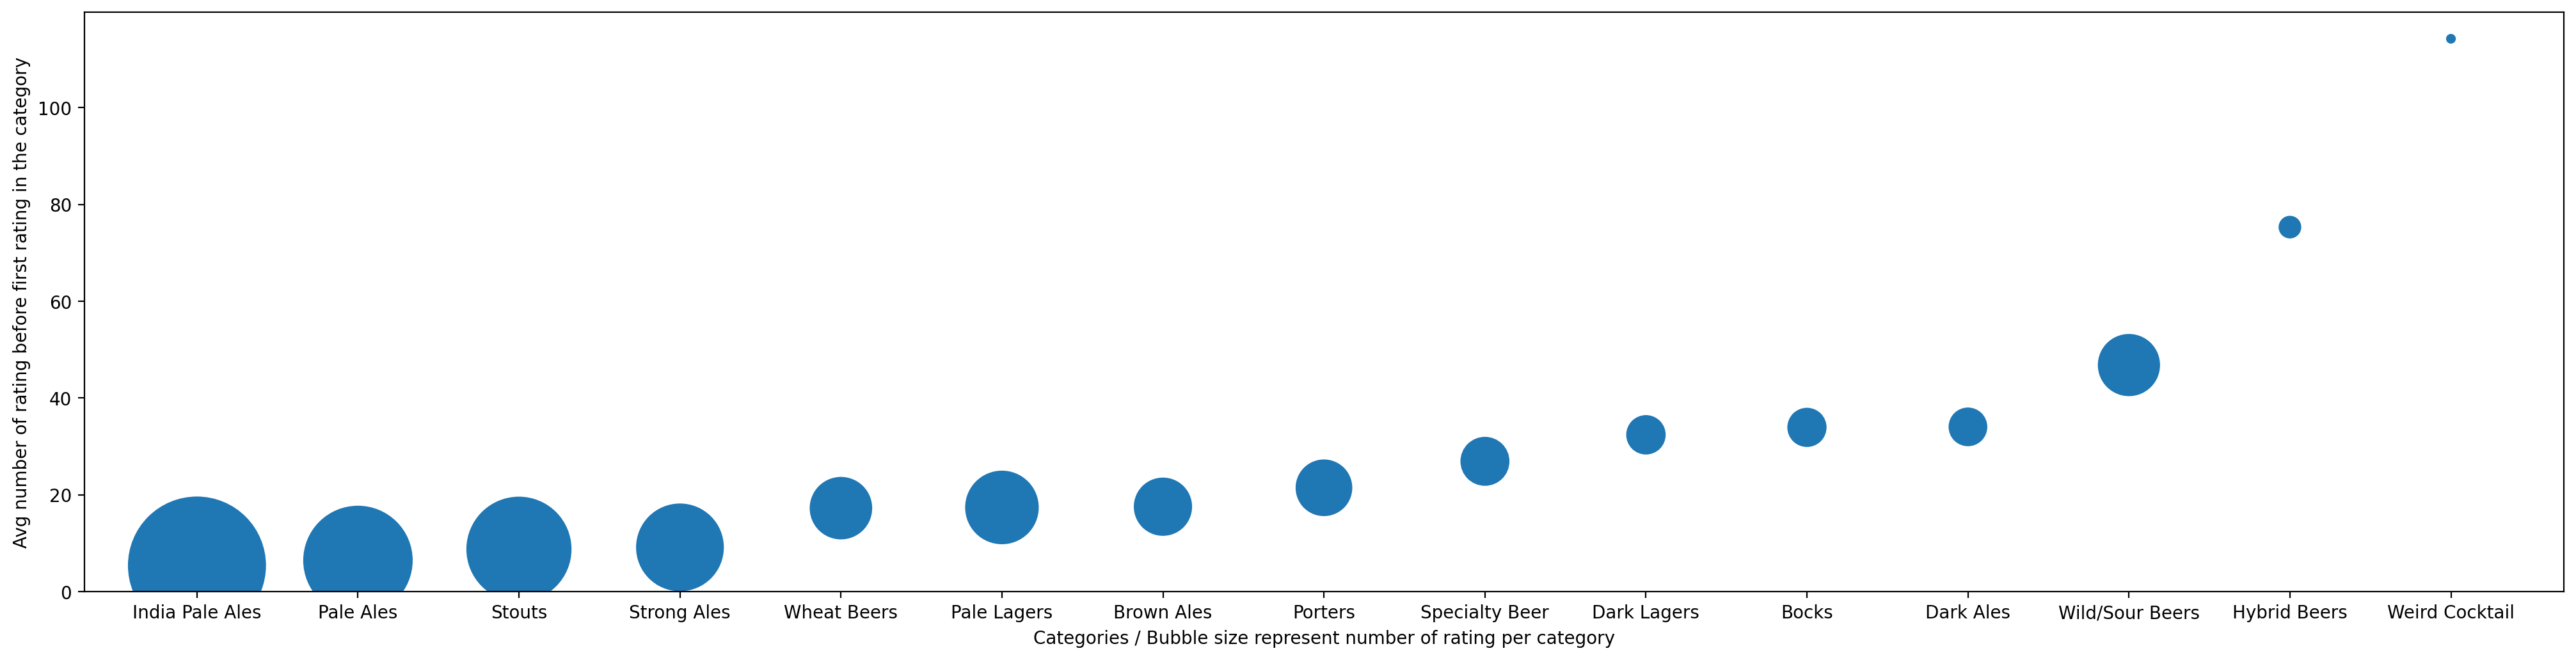

In [8]:
plt.figure(figsize=(25, 6), dpi=200)
plt.scatter(rating_order["category"], rating_order["mean first rating number"], s=rating_order["number of rating"]/200)
plt.xlabel("Categories / Bubble size represent number of rating per category")
plt.ylabel("Avg number of rating before first rating in the category")


This scatter plot shows the average path a user will follow during its exploration of the different categories. The India Pale Ales are the gatataw to beer tasting, it is therefore logical to see that the makority of ratings are in this category. The categories on the right can be considered "expert" beers, and in general, the users will try them last. The Wild/Sour Beers category is an outlier, it is rated a lot but by more experimented users.

As the distributions are heavy-tailed, the median could lead to more pertinent results. Nevertheless, it could be possible to identify experimented users with theses results and analyse their path, thus eliminating the noise due to the users that never become experts.

## Ratio of number of rating per category evolution over the "career" of a user

In [9]:
rating_num = df_ratings.copy()
rating_num.sort_values(by = "date", inplace=True)
#rating_num["id"] = range(len(rating_num))
rating_num["rating number"] = np.zeros(len(rating_num))
rating_num["rating number"] = rating_num.groupby("user_name").transform("cumcount")

In [10]:
rating_num["sum"] = rating_num.groupby("rating number").transform("count").reset_index()["beer_id"].values
rating_num["sum cat"] = rating_num.groupby(["rating number", "category"]).transform("count").reset_index()["beer_id"].values
rating_num["ratio"] = rating_num["sum cat"]/rating_num["sum"]

In [11]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

<Figure size 5000x5000 with 0 Axes>

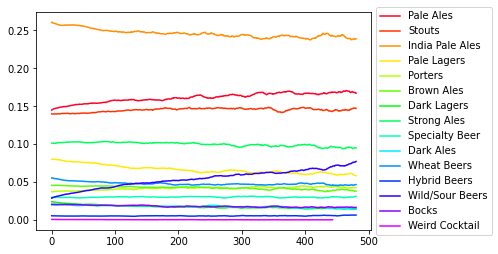

In [14]:
plt.figure(figsize=(25, 25), dpi=200)
cm = plt.get_cmap('gist_rainbow')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[cm(1.*i/15) for i in range(15)])
for cat in cats:
    temp = rating_num[(rating_num["category"]==cat) & (rating_num["rating number"] < 500)].groupby("rating number").first()["ratio"].values
    ax.plot(moving_average(temp, 20))
    #ax.plot(np.add.reduceat(temp, np.arange(0, len(temp), 20))/20)
ax.legend(cats, loc='center left', bbox_to_anchor=(1, 0.5))


# Graph

In [110]:
g_cat = nx.DiGraph()
g_cat2 = nx.DiGraph()
# Create every edges with weight zero
for cat_1 in cats:
    for cat_2 in cats:
        g_cat.add_edge(cat_1, cat_2, weight=0)
        g_cat2.add_edge(cat_1, cat_2, weight=0)

For each rating, we add weight to the transition from the last rating's category.
In a second time, we assign the rating of the destination category to the edge, following the logic that a taste transition is more important if the new beer category is enjoyed.

In [111]:
# For each rating, add the rating to the edge corresponding
df_ratings.sort_values(by = "date", inplace=True)
ratings_user = df_ratings.groupby("user_name")
for user, group in ratings_user:
    for cat_1, cat_2, rating in zip(group["category"], group["category"][1:], group["rating"][1:]):
        weight_add = g_cat[cat_1][cat_2]["weight"] + round(rating, 3)
        g_cat.add_edge(cat_1, cat_2, weight=weight_add)
        weight_add2 = g_cat2[cat_1][cat_2]["weight"] + 1
        g_cat2.add_edge(cat_1, cat_2, weight=weight_add2)

/var/folders/ws/5p7_136x319bkvrsb50zkt600000gn/T/ipykernel_35923/720680514.py:5: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  for cat_1, cat_2, rating in zip(group["category"], group["category"][1:], group["rating"][1:]):


We apply a threshold on the edges to keep only the most relevant ones. The isolated nodes are then removed.

In [112]:
threshold = 200000

# filter out all edges bellow threshold and grab id's
short_edges = list(filter(lambda e: e[2] < threshold, (e for e in g_cat.edges.data('weight'))))
le_ids = list(e[:2] for e in short_edges)

# remove filtered edges from graph G
g_cat.remove_edges_from(le_ids)

isolated_nodes = list(nx.isolates(g_cat))
g_cat.remove_nodes_from(isolated_nodes)

In [113]:
threshold = 50000

# filter out all edges bellow threshold and grab id's
short_edges = list(filter(lambda e: e[2] < threshold, (e for e in g_cat2.edges.data('weight'))))
le_ids = list(e[:2] for e in short_edges)

# remove filtered edges from graph G
g_cat2.remove_edges_from(le_ids)

isolated_nodes = list(nx.isolates(g_cat2))
g_cat2.remove_nodes_from(isolated_nodes)

A weight equal to the sum of the weight of the arriving arrows is then assigned to each nodes.

In [114]:
node_weight = []
for styles in g_cat.nodes:
    weight_sum = 0
    for in_edge in g_cat.in_edges(styles):
        weight_sum += g_cat[in_edge[0]][in_edge[1]]["weight"]
    node_weight.append(weight_sum/4000)


In [107]:
node_weight2 = []
for styles in g_cat2.nodes:
    weight_sum = 0
    for in_edge in g_cat2.in_edges(styles):
        weight_sum += g_cat2[in_edge[0]][in_edge[1]]["weight"]
    node_weight2.append(weight_sum/1000)

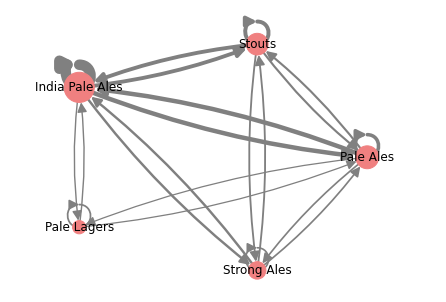

In [115]:
labels = nx.get_edge_attributes(g_cat2,'weight')
pos=nx.circular_layout(g_cat2)
edge_width = [w/40000 for (*edge, w) in g_cat2.edges.data("weight")]

 
nx.draw(g_cat2, pos, with_labels=True, edge_color="gray", node_color="lightcoral", \
         font_color="k", connectionstyle="arc3, rad=.07", width=edge_width, arrowsize=20, \
         node_size = node_weight2)
x_values, y_values = zip(*pos.values())
x_max = max(x_values)
x_min = min(x_values)
x_margin = (x_max - x_min) * 0.25
plt.xlim(x_min - x_margin, x_max + x_margin)
plt.show()

There is no clear path, however the 4 most rated categories clearly appear. A metric to asses if a user has "experimented" a new category would help to eliminate the noise of all the goings and comings between the categories.

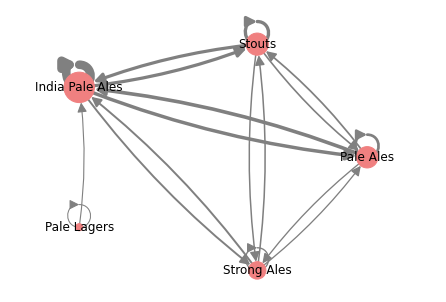

In [116]:
labels = nx.get_edge_attributes(g_cat,'weight')
pos=nx.circular_layout(g_cat)
edge_width = [w/200000 for (*edge, w) in g_cat.edges.data("weight")]

 
nx.draw(g_cat, pos, with_labels=True, edge_color="gray", node_color="lightcoral", \
         font_color="k", connectionstyle="arc3, rad=.07", width=edge_width, arrowsize=20, \
         node_size = node_weight)
x_values, y_values = zip(*pos.values())
x_max = max(x_values)
x_min = min(x_values)
x_margin = (x_max - x_min) * 0.25
plt.xlim(x_min - x_margin, x_max + x_margin)
plt.show()

There is no clear difference when the rating is taken into acount.